# Pre-Processing the data

We cannot pass the data as it is to the model to be trained, we need to pre-process it to extract maximum amount of features from the image. So now we will perform **Data Augmentation** on our dataset, to normalize the image, to add some extra features and make images ready to be passed to train the model.

Here we are going to use the ```ImageDataGenerator``` class to perform the **Data Augmentation** on dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Let's fix the ```INPUT_SHAPE``` because the images we have in our dataset are not in same size. So it is important to have the same size of images. 

In [2]:
# Size Of Input Image and No. of images in a Batch
INPUT_SIZE = [100,100]
BATCH = 32

In [3]:
training_datagen = ImageDataGenerator(rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range = 0.2,
                                      )

training_data = training_datagen.flow_from_directory('./Face Mask Dataset/Train',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary'
                                                     )

Found 10000 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = training_datagen.flow_from_directory('./Face Mask Dataset/Test',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary'
                                                     )

Found 1792 images belonging to 2 classes.


Now, our data is ready to be passed to train the model. 

# Importing VGG16 Model's Architecture

In this step we are going to import the ```VGG16``` architecture from ```keras```. ```VGG16``` is a winner of ```imagenet``` compitition in 2014. So, we are going to use the same weights used to train actual VGG16 Image Classification model from that compitition. This will save our lots time and lots of resources too. 

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

Following is code which we will be using to import the ```VGG16``` architecture. We will pass the three parameters, that are input size of an image, ```weights="imagenet"``` and ```include_top=Flase```.

```include_top``` is false because we don't need to import whole architecture. We need only the **Convolutional architecture** of VGG16. After that we will add our layer and which will be trained according to our dataset.

In [6]:
vgg16 = VGG16(input_shape=INPUT_SIZE + [3], weights='imagenet', include_top=False)

We imported the VGG16 architecture but we need to freeze the weight to prevent it from changing in **Backpropogation** process.

In [7]:
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Above you can see the VGG16 architecture, there are total ```14,714,688``` parameters but they are non-trainable because we freezed them. They will not change in backpropogation. 

Now we need to add some more trainable layer which will be trained according to our dataset. 

In [9]:
flatten = Flatten()(vgg16.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)
dense_output = Dense(units=1, activation='sigmoid')(dense_4)




In [10]:
model = Model(inputs=vgg16.input, outputs=dense_output)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Above is our model architecture that we are going to use. 



# Training The Model

Now,our dataset and Model both are ready to be utilized. Let's train our model.

In [12]:
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

Using TensorFlow backend.


In [13]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy', sensitivity, specificity]
)


In [14]:
my_model = model.fit(training_data, epochs=25, validation_data=test_data) 


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 56 steps
Epoch 1/25
313/313 [==============================] - 1895s 6s/step - loss: 0.0849 - accuracy: 0.9668 - sensitivity: 0.9634 - specificity: 0.9677 - val_loss: 0.0683 - val_accuracy: 0.9794 - val_sensitivity: 0.9590 - val_specificity: 1.0000
Epoch 2/25
313/313 [==============================] - 2011s 6s/step - loss: 0.0330 - accuracy: 0.9885 - sensitivity: 0.9855 - specificity: 0.9917 - val_loss: 0.0257 - val_accuracy: 0.9933 - val_sensitivity: 0.9932 - val_specificity: 0.9943
Epoch 3/25
313/313 [==============================] - 2740s 9s/step - loss: 0.0320 - accuracy: 0.9897 - sensitivity: 0.9866 - specificity: 0.9928 - val_loss: 0.0320 - val_accuracy: 0.9905 - val_sensitivity: 0.9956 - val_specificity: 0.9858
Epoch 4/25
313/313 [==============================] - 3130s 10s/step - loss: 0.0239 - accuracy: 0.9917 - sensitivity: 0.9902 - specificity: 0.9936 - val_loss: 0.0145 - val_accuracy: 0.996

In [15]:
model.save('face_mask_detection.h5')

# Visualizing Training of Model

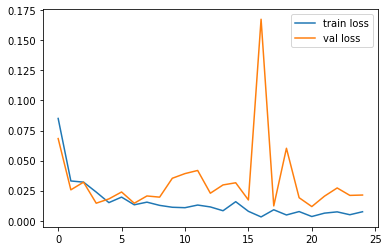

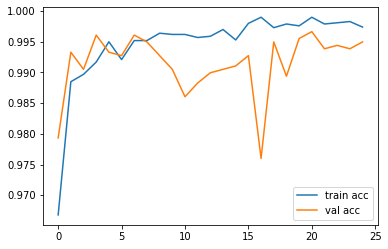

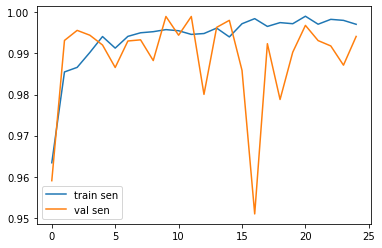

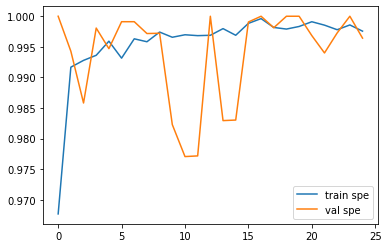

<Figure size 432x288 with 0 Axes>

In [16]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(my_model.history['loss'], label='train loss')
plt.plot(my_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(my_model.history['accuracy'], label='train acc')
plt.plot(my_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# plot the sensitivity
plt.plot(my_model.history['sensitivity'], label='train sen')
plt.plot(my_model.history['val_sensitivity'], label='val sen')
plt.legend()
plt.show()
plt.savefig('SenVal_sen')

# plot the specificity
plt.plot(my_model.history['specificity'], label='train spe')
plt.plot(my_model.history['val_specificity'], label='val spe')
plt.legend()
plt.show()
plt.savefig('SpeVal_spe')

# Testing the Model

In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('./Face Mask Dataset/Test/WithoutMask/1348.png', target_size = INPUT_SIZE)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result[0][0]

1.0

In [18]:
if result[0][0] < 0.5:
    print('Image classified as With MAsk')
else:
    print('Image classified as Without Mask')

Image classified as Without Mask


# Detecting Face Masks

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np

In [20]:
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [21]:
dependencies = {
    'sensitivity': sensitivity,
    'specificity': specificity
}

model = load_model('face_mask_detection.h5', custom_objects=dependencies)

In [22]:

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'WITHOUT MASK',1:'WITH MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}

In [23]:
while(True):

    ret,img=source.read()
    faces=face_clsfr.detectMultiScale(img,1.3,5)  

    for (x,y,w,h) in faces:
        resized_img=cv2.resize(img,(100,100))
        img_array = image.img_to_array(resized_img)
        normalized_img= img_array/255
        reshaped_img = np.expand_dims(normalized_img, axis = 0)
        result=model.predict(reshaped_img)
        
        if result[0][0] < 0.5:
            label = 0
        else:
            label = 1
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()